In [1]:
#boilerplate
import numpy as np
import scipy.stats as stat
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import scipy.optimize as opt
import imageio as io

# Project 2: PDEs
As stated in the project description on Canvas, in spy movies, they sometimes are able to "zoom and enhance" on a previously grainy image taken by a traffic camera or some other public surveillance system. In these scenes, we are clearly able to make out details that were otherwise not plainly visible in the first rendering. In project 1, we shot a clown out of a cannon, in hopes of shooting him from one part of the globe to another part of the globe. In some of these cases, the predicted launch speed was pretty insane, sometimes approaching 1% the speed of light. If our hero were crossing an intersection at very high speeds, and the traffic camera flashed his picture at just the right moment, we would think that all that we could see was a blur as the clown whizzes by. Would we be able to make out the clown? How much are we able to "zoom and enhance?"

In this project, we want to use PDEs in an application to images to try to restore them. To do so, we need to break down what we're actually intending to do. Digital images (namely greyscale images) are just 2D arrays of values, telling us the value of the intensity at each pixel. If we have some portion of the image that has been damaged, we want to be able to know what the intensity of each missing pixel was intended to be. To do this, we can use the Laplace equation for inward propagation of intensities. 

## Background: Working with Laplace Equation
The Laplace equation appears as $$\delta I(\vec{x}) = 0$$ where $\delta = \vec{\bigtriangledown}^2$ or $\delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$, $\vec{x} = (x,y)$, and $I(\vec{x})$ is the matrix containing the intensity information.
We want to use Dirichlet boundary conditions (where we specify the value of the function at the boundary) to solve the PDE in order to fill in the missing information. Note that this technique does not work for "big regions". What counts as too big? We suppose we will want to find out. 
Here we attempt to implement the laplace equation with the form, 
$$\rho(x,y) = \frac{\partial^{2}{I}}{\partial{y}^{2}} + \frac{\partial^{2}{I}}{\partial{x}^2}$$
where $I(x,y)$ is the picture function. No source terms gives a solution function $u(x,y)$ as 
$$0 = \frac{\partial^{2}{u}}{\partial{y}^{2}} + \frac{\partial^{2}{u}}{\partial{x}^{2}}$$
which means we need to discretize to do this numerically so we will do this on a grid with step size $\Delta x = \Delta y == \Delta$
such that for all points $\in x,y$ we can define $x_{j} = x_{0} + j \Delta$ and $y_{l} = y_{0} + l \Delta$ for $j = 0,...,J$ and $l = 0,...,L$

Using center differencing with our grid we get the equation,
$$ 0 = \frac{u_{j+1,l} + u_{j,l+1} + u_{j-1,l} + u_{j,l-1} - 4u_{j,l}}{\Delta^2} $$
we want to solve this as a system of linear equations and solve in the form $\underline{A}\vec{u} = \vec{b}$. To do this we have to do a little finesse. The finess is for a couple reasons. For one, we need to make the BCs part of $\vec{b}$, and secondly we need to change $u_{j,l}$ to a 1-D array.

We use Direchlet BCs, which means we know $u_{j,l}$ when $j=0,J$ and $l=0,L$. Consequently, we can move those terms to the LHS of the equation and make that an element of $\vec{b}$, but first let's worry about making $u_{j,l}$ a 1-D array.

we can map $u_{j,l}$ to a 1-D array $u_{i}$ by defining $i = j(L+1) + l$ for $j = 0,...,J$ and $l = 0,...,L$ which means for the interior points ($j=1,...,J-1$ and $l=1,...,L-1$) our equationn becomes
$$ 0 = \frac{u_{i+(L+1)} + u_{i+1} + u_{i-(L+1)} + u_{i-1} - 4u_{i}}{\Delta^2} $$ 
where the new $u$'s are in the same order at the previous eqn. 

As for the BCs, they have been mapped in this way,
$$
\begin{align}
j&=0  &  i &= 0,1,...,L \\
j&=J  &  i &= J(L+1),J(L+1)+1,...,J(L+1)+L \\
l&=0  &  i &= 0,L+1,2(L+1),...,J(L+1) \\
l&=L  &  i &= L,L+1+L,2(L+1)+L,...,J(L+1)+L
\end{align}
$$
and so at those $u_{i}$ values we can moves those terms over to $\vec{b}$

which gives us $\underline{A}\vec{u} = \vec{b}$. 

We pursued this method for a while, but ultimatlely unfortunately during our implementation testing of our FD method for solving the Laplace eqn, we encountered the issue that the matrix solver library in 'scipy.linalg' could not handle our matrix, and while it would have been great to find a way to make this matrix easier to handle computationally, it seemed out of reach within the deadline. So we have now decided to move onto another, hopefully more succesful method.

## Second Try: Fourier Methods
Since the eigenfunctions to the laplace equation are harmonic, we wanted to try a spectral method as that would do away with the issues we encountered in our fourier (get it lol, like foray lmao) into FD methods.

So we went off of the frame work from numerical methods and are going to implement the FT on homongenous dirchlet boundary conditions. With the same discritized grid we have been using before.

Why/how can we do this? If you consider our picture to be one in an infinte 2-D grid of that picture, like a patchwork quilt, all of a sudden we have the periodic boundary conditions nessecary for a FT solution. The reason we can say this is that we are now going to use the entire image as our boundary but still try to solve for a small region. So while our FD method had $\rho=0,$ but for this method we are now using the whole image as our source term. So in order to implement this, start by defining the FT of some matrix or vec $Q$ to be $Q^*$. Our equation now becomes,
$$ \nabla^{2} u^* = \rho^* $$
So now we can expand $u$ and $\rho$ in terms of sines over our discritized grid,
$$u_{m,n}^{*} = \frac{4}{JL}\sum_{j=1}^{J-1}\sum_{l=1}^{L-1} u_{j,l} 
sin \left(\frac{\pi j m}{J}\right) sin \left(\frac{\pi l n}{L}\right)$$
and our $\rho$ can now be expressed as,
$$\rho_{m,n}^{*} = \sum_{j=1}^{J-1}\sum_{l=1}^{L-1} \rho_{j,l} 
sin \left(\frac{\pi j m}{J}\right) sin \left(\frac{\pi l n}{L}\right)$$
And now from using our FD scheme in fourier space we can solve for $u^*$ in terms of $\rho^*$ as,
$$ u_{m,n}^{*} = \frac{\Delta^{2}\rho_{m,n}^{*}}{2\left( cos\left(\frac{2\pi m}{J} \right) cos\left(\frac{2\pi n}{L} \right) - 2 \right)} $$
and from there, viola, we are just a FT away from an inpainted image.

## Other Methodology

### Chi-squared fit

Beyond visually confirming that our algorithm is able to restore or zoom in on an image, we would like some sort of quantifiable measure of success for our algorithm. Where here we can define a chi^2, $$\chi ^2=\frac{\frac{1}{n}\sum_{x,y}[I_{restored}(x,y)-I(x,y)]^2}{\sigma^2} $$
$$ \sigma^2= \frac{1}{n-1}\sum_{x,y}[I(x,y)-I_{mean}]^2$$.
 This not only allows us to say with concrete evidence how well our implementation does at inpainting but we can also use this metric to determine the relationship between different parameters and the success of our algorithm. Different parameters could be, the size of the hole or amount of zoom, the shape of the hole or how we zoom out, we can also use this to compare different implementations.
 
### Diffusion Equation 
In order to prevent the problem of random noise in our calculations diffusion must be done in between inpainting. This diffusion must preserve the shape of the objects present in the image as well namely the straight lines that are present. By setting curvature as the anisotropic diffusion constant in our equation we are able to preserve these straight lines while removing some of the random noise present in the picture. This equation is of the form $$\frac{\partial I}{\partial t}=\kappa |\nabla I|$$ where $\kappa$ is the curvature at a given point in the matrix I. This can be expanded into the form 
$$\frac{\partial I}{\partial t}=\frac{\frac{\partial^2 I}{\partial y^2}(\frac{\partial I}{\partial x})^2+\frac{\partial^2 I}{\partial x^2}(\frac{\partial I}{\partial y})^2-2\frac{\partial^2 I}{\partial x \partial y}\frac{\partial I}{\partial x}\frac{\partial I}{\partial y}}{(\frac{\partial I}{\partial x})^2+(\frac{\partial I}{\partial y})^2} \quad(1).$$
We can then use the FTCS scheme to create a discrete form of the equation. Using Von-Neumann analysis to analyse for stability we can find 
$$\frac{\zeta-1}{\Delta t}=\frac{(e^{ik_y\Delta}+e^{-ik_y\Delta}-2)(e^{ik_x\Delta}-e^{ik_x\Delta})^2+(e^{ik_x\Delta}+e^{-ik_x\Delta}-2)(e^{ik_y\Delta}-e^{ik_y\Delta})^2-\frac{1}{2}(e^{ik_x\Delta}-e^{ik_x\Delta})(e^{ik_y\Delta}-e^{ik_y\Delta})(e^{ik_x\Delta}e^{ik_y\Delta}-e^{-ik_x\Delta}e^{ik_y\Delta}-e^{ik_x\Delta}e^{-ik_y\Delta}+e^{-ik_x\Delta}e^{-ik_y\Delta})}{\Delta^2[(e^{ik_x\Delta}-e^{ik_x\Delta})^2+(e^{ik_y\Delta}-e^{ik_y\Delta})^2]}\quad(2).$$
This can be simplified to 
$$ \zeta=\frac{2\Delta t}{\Delta^2} \frac{(\cos(k_y\Delta)-1)\sin^2(k_x\Delta)+(\cos(k_x\Delta)-1)\sin^2(k_y\Delta)+\sin^2(k_x\Delta)\sin^2(k_y\Delta)}{\sin^2(k_x\Delta)+\sin^2(k_y\Delta)}+1 \quad(3).$$
stability can be shown by choosing a value for $k_x\Delta$ and then looking for stability in $k_y\Delta$. By picking the values $0,\pi/2,\pi$ and $3\pi/2$ we are picking the minima and maxima of the sinusoid values, therefore, if these points are stable then we can see that the algorithim as a whole is stable. Additionally we can see that all the sin terms are squared so we know that $\pi/2$ and $3\pi/2$ give identical results so we only need to consider one of them. Taking a look at the case where $k_x\Delta=\pi/2$ we get the equation
$$ \zeta=\frac{2\Delta t}{\Delta^2}\frac{-\sin^2(k_y\Delta)+\cos(k_y\Delta)-1+\sin^2(k_y\Delta)}{\sin^2(k_y\Delta)+1}+1 \quad(4).$$ The algorithim is stable when $\zeta \leq 1 $ so from this we can get the equation
$$ \frac{2\Delta t}{\Delta^2}\frac{\cos(k_y\Delta)-1}{\sin^2(k_y\Delta)+1}\leq 0 \quad(5).$$
which shows that the algorithim is unconditionally stable. In the case where $k_x\Delta=0$ or $\pi$ the fraction containing the sinusoids reduces to $0$ and $-1$ respectively. This also shows that the algorithim is unconditionally stable. Taking a look at the equation $(3)$ we see that $\zeta$ approaches zero and phase errors are minimized when $\Delta^2$ is much larger than $\Delta t$. In addition it is important to keep $\Delta^2\geq\Delta t$ so to prevent shocks to we let $\Delta^2=5\Delta t$

## Updates on issues raised from phase 1
*Why are we using 8 bit images?* 
We plan to use 8 bit images because these provide sufficient resolution and are the most simple to work with. This simplifies computation because each pixel can then be accessed individually as one full byte. Almost all image file formats support 8 bit resolutions, so in practice we could use any type of file we wanted, but this may involve using different Python methods when reading the image files (we aren't presently sure about which methods can read which kinds of files yet), so we probably be restricted (at least initially) to using whatever file type our method supports.  

*How will we handle the fact that the solutions will return non-integer values?*
It is rather tricky that we will be using pixels represented by integers, when in reality the solutions of the PDEs will return non-integer values. This necessarily means that we will be losing precision at every pixel when we compute a solution, but the best we can do is round the solution at each pixel to the nearest integer.

*A "force" to be reckoned with*
In the development/testing, there is some "force" to be included. How do we determine or optimize this function? How universal is this function, or in other words, how widely can we apply one optimized force function? There seems to be a tradeoff here. On one hand, in order for it to be more widely applicable, the function should be more general, which makes it less optimized. Conversely, if we optimize the function for one image based on its known properties (or what we know it's supposed to look like), then this function might not be generalizable to other functions. How do we deal with this? It seems to make sense to us that this function could be a polynomial with a few terms (almost like a cubic spline?) which is generalizable enough to be applied to many problems, but with enough precision that it does not distort the image quality.

*RGB clarification*
In practice, the RGB case should be relatively easy to include since it should actually just be doing the same thing two more times, but each of these three color arrays should be stored and solved individually because the red array might change in a manner that is different from the blue array, which might also differ from the green array, and vice versa. This will affect the efficiency of our code in both speed and storage space considerations, because this means that we need to store and operate on three separate matrices, which is not the best, but hopefully doesn't affect the speed or storage too notably. If we are using incedibly large images, we may start running into problems, but images that are a few thousand pixels across should be okay. We could shortcut by assuming that all three matrices will change the same way and then only solving once and applying the solution to each of the three matrices, but we will choose not to do this because it seems risky to do so in terms of image distortion.
There also appears to be a potential for spurious colors to appear when layering color grids on top of one another, but we choose to ignore this, as these corrections are difficult and minor. 

## Phase 2: Helper functions library
In phase 2, we did a lot of work involving some helper functions that ultimately we used in our implementation to cut holes in the pictures where we wanted, or if we wanted to diffuse the images, or if we wanted only the boundary conditions or things like that. Those are all now stored in our own little python library, which is resting safely in our git. It is called phase2_project2.py and we can import it and call functions from it, as shown below. We call it for our square clown image, which is super creepy, and then try diffusion on the bird image which is less creepy! 

*Please note* that even though when we call cmap = "gray" in plt.imshow, this isn't the only thing that makes our image black and white. The images that we import are RGB color images, which are 3D matrices with R, G, and B information for each pixel. We have created a function which averages these and then returns the picture with one value per pixel, which is essentially an 8-bit image. 

In [2]:
#importing the library
import project2_phase2 as p2p2

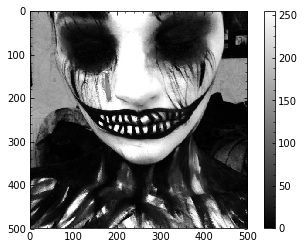

In [3]:
clown = io.imread('clown.jpg')
clown_grey = p2p2.make_greyscale(clown)
plt.imshow(clown_grey, cmap = "gray");
plt.colorbar()

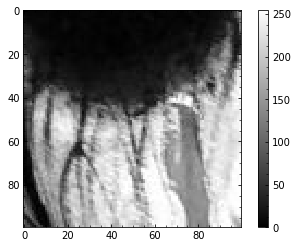

In [4]:
zoom_clown = p2p2.zoom_in(clown_grey,start = (100,100), window_size = (100,100))
plt.imshow(zoom_clown, cmap = "gray")
plt.colorbar()

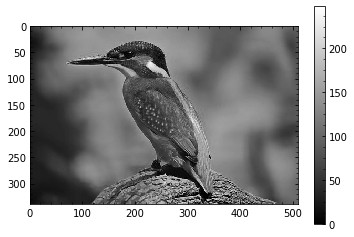

In [5]:
#let's show this bird and then diffuse the bird a little
bird = io.imread('bird.jpg')
bird_grey = p2p2.make_greyscale(bird)
plt.imshow(bird_grey, cmap = 'gray')
plt.colorbar()

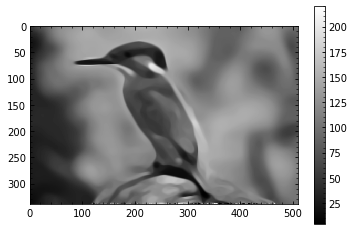

In [6]:
diffused_bird = p2p2.diffusion(bird_grey,100)
plt.imshow(diffused_bird, cmap = "gray")
plt.colorbar()

## Further bug fixes from phase 2
We had to perform a few bug fixes on the functions we made for phase 2 in order to get things straight for phase 3. 

*non-square images* 
In phase 2, we never tested non-square images, which led to a few of our functions not being generalized to non-square images. For example, we tested and messed with window_boundaries function more and found that it only works with symmetric (square) pictures because the function as written cannot broadcast the matrix to another shape. We wrote a new function called window_bounds which is more general and can now handle asymmetric pictures. 

*diffusion mask* 
A further bug fix was for diffusion, where we added a mask so that when we pass positions in the matrix that we want to diffuse over, we can do those instead of diffusing over the entire image.

*chi-squared* 
Furthermore, we realized that the previous chi_squared method was wrong, as well. It did not handle places where the real image was zero, because it divided the difference between the real and smoothed images by the real image, leading to divide by zero errors. Instead, we created our own chisquared method, which appears in project2_phase2.py. The function takes the difference between the observed and expected matrices, squares that value, sums it in both dimensions, and then divides by the size of the expected matrix. Then, we use the stat.tstd function to find the standard deviation, and divide by the standard deviation squared, dividing again by the size of the expected matrix to account for normalization.

*aspect ratio*
another feature we added as we have been trying to solve the problem has been the ability to use an aspect ratio. Previously the window that we created would have the pixel size of the original image, we have allowed for modulation of this feature in order to make the inpainting region more managable.

### Phase 3 Goals and plan of attack
In this phase, we will implement the inpainting scheme and the tests that we put forth in phase 2. we plan to first take our clown image  and remove a portion of the image. We would perform diffusion on the entire image to smooth out the image slightly. We would then perform steps of inpainting alternating with steps of diffusion only on the empty region with known boundaries in order to fill in the hole and then smooth out any noise that appears. Then after the inpainted region has been filled we would perform the chisquared analysis between the observed inpainted image and the 'expected'(original) image. We will do this for different sizes of the missing region and to determine the behavior of the chi squared metric. We can also look qualitatively at the image to determine when significant changes begin to appear. We can also perform this test on the 'pixval' array as it has much easier behavior compared to the clown image and therefore should allow the laplace equation to fill in a larger region. 

## Laplace Equation matrix
The next feature that has an update has been our implementation in solving the laplace equation. As a reminder we started with a simple finite element method that we hoped the 'scipy.linalg' library could handle. More after we show you our current implementation below.

In [7]:
def make_ab(n,BC):
    '''
    here were gonna make A and vector b to solve the linear sys of eqn of the form Au=b
    A should be a banded tri diag matrix and b is gonna be = 0 except for the boundary points
    assumes square grid, and no source terms, see markdown above for how it should be that is easier on the eyes
    also doesnt return a sparse ass matrix cuz thats silly
    as of (10/27) this is going to be used for implentation in 'la.solveh_banded' WITH 'lower'=TRUE
    as of (10/27) assumes that a nxn pixel picture that we want to inpaint translates to an n*(n+1)+n by n*(n+1)+n matrix because
    of going from an nxn matrix for u_j,l into a 1-d array u_i
    it is being implemented in a similar fashion to Numerical Recipes 3rd, chap. 20
    inputs:
    n - integer, the number of pixels in the region of the picture we are trying to solve (either the zooomed or chunk removed version)
    note n = J = L
    BC - 4xJ(or L) array, array with values at the boundary, see 'window_boundaries' function for full doc but
        0th row - l=0
        1st row - l=L
        2nd row - j=0
        3rd row - j=J
    outputs: as a tuple (A,b)
    A - (n+1)xi array, the matrix A, where the values go from the diag to the last top-most non-zero diagonal,
    basically the upper triangular (kinda), of A
    b - len(i) 1-d array, long array, RHS of eqn, mostly 0's but with boundary terms
    '''
    i = np.linspace(0,(n*(n+1)+n),(n*(n+1)+n)+1,dtype=int)
    b = np.zeros(i[-1])
    # lets do b first 
    b[0:n] = BC[2,:]
    b[n*(n+1)::] = BC[3,:]
    b[:n*(n+1):(n+1)] = BC[0,:]
    b[n::(n+1)] = BC[1,:]
#     # now time for A
    lowa = np.ones(((n),i[-1]))
    lowa[0,::n] = lowa[1,(n-1)::n] = lowa[1,-2::] = 0 #second diag
    lowa[1:-1:,:] = 0 #now i gotta make all the other guys 0 now
    lowa[-1,::n] = lowa[-1,(n-1)::n] = lowa[-1,-(n+2)::] = 0 #final non zero diag
    test = np.ones(((2*n+1),i[-1]))
    test[:n:,:] = lowa[::-1]
    test[n,::n] = test[n+1,-1] = -0.
    test[n,:] *= -4.
    test[n+1::,:] = lowa
    del lowa
    return (test[:,1:-1:],b)

# Fourier analysis time

In [8]:
def sol(rho):
    """
    Transforms square force matrix rho in matrix values u for laplace's equation in frequency space
    
    Params
    ------
    rho : ndarray
      2-Dimensional matrix of the force terms of laplace's equation
    
    Returns
    -------
    sol : ndarray
      The solution u in the frequency domain in a matrix of size rho
    """
    delta=1/rho.shape[0]
    J,L=rho.shape
    a,b=np.mgrid[0:J,0:L]
    denom=2*(np.cos(2*np.pi*a/J)+np.cos(2*np.pi*b/L)-2)
    u=rho
    u[1:,1:]=rho[1:,1:]*delta**2/denom[1:,1:]
    return u

In [9]:
def inpaint(init,start,window_size,time=0):
    """
    Takes a an initial image init and performs inpainting in the region indicated by start and window size
    
    Params
    ------
    init : ndarray
      2-Dimensional matrix of the image to be inpainted
    start : ndarray
      (2,) array with the (x,y) coordinates of the top left of the region to be inpainted
    window_size : ndarray
      (2,) array with the (x,y) dimensions of the hole to be inpainted
    time : int
        time you would like for diffusion to be run, if none set to =0
    
    Returns
    -------
    final : ndarray
      The image with the inpainted region covered
    """
    final=np.copy(init)
    step=np.copy(init)
    xo,yo=start
    xf,yf=start+window_size
    length=init.shape[0]
    for i in range((xf-xo)//2+1):
        #p2p2.diffusion(step,T=time) #we can try this to see if it works just increase T for more diffusion
        F=fft.dstn(step,type=1)
        plz=sol(F)
        step=fft.idstn(plz,type=1)/((2*np.sqrt(F.size))**2) 
        J,L=final.shape
        j,l=step.shape
        dj=int ((J-j)/2)
        dl=int ((L-l)/2)
        final[i+xo:xf-i,i+yo:yf-i]=step[i+xo:xf-i,i+yo:yf-i]
    #an attempt to make the masking function work, but it did not
    #B = np.zeros([2,xf-xo], dtype = int)
    #B[0] = np.arange(xo,xf)
    #B[1] = np.arange(yo,yf)
    #note! please use a square hole
    final = p2p2.diffusion(final,time)
    plt.imshow(final,cmap ="gray")
    return final

Let's take this baby for a spin and see how he does. You'll be able to see where we cut the hole, but you can also see that the inpainting does a decent job of recreating the image! WE'll zoom in on it next to see what it actually looks like. Additionally, we can perform the chi-squared analysis that we said we would perform for you, to see how well we did in a more quantitative sense.

Another thing to note that we did in our implementation we choose the 'type I' convention for our DTF and iDFT. This convention is write exactly like above in the note about our implementation. This is a choice we are free to make, it obviously has pros and cons which vary depending on the situation that we are in and our situation dictated we choose Type I.

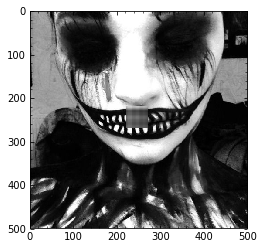

In [10]:
start=np.array([220,220])
window_size=np.array([50,50])
init=p2p2.make_hole(clown_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)

The chi-squared value for this guy is  3.382624568623126e-08


'This seems pretty small! Note that this chi-squared value is for the entire image. \nFor the majority of the image, the difference \nshould literally be zero. It is only in the window that we want to test the chi-squared.\nSo we can do that.'

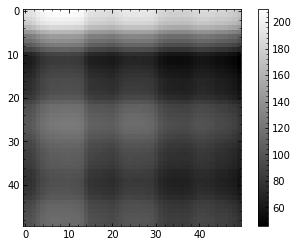

In [11]:
#zoomed in inpainted region, T=0
xo,yo=start
xf,yf=start+window_size
plt.imshow(f[xo:xf,yo:yf],cmap ="gray")
plt.colorbar()
chisq =p2p2.chisquared(f,clown_grey)
print("The chi-squared value for this guy is ", chisq)
"""This seems pretty small! Note that this chi-squared value is for the entire image. 
For the majority of the image, the difference 
should literally be zero. It is only in the window that we want to test the chi-squared.
So we can do that."""

In [12]:
#chi-squared test for just the window parts of the image
chisq2 = p2p2.chisquared(f[xo:xf,yo:yf],clown_grey[xo:xf,yo:yf])
print("okay the chi-squared value for just this part of the image is", chisq2)

okay the chi-squared value for just this part of the image is 0.00034095748135913096


We can also show you just the zoomed in portion and also diffuse it for a little, and test the chi-squared vs different diffusion times.

okay the chi-squared value for just this part of the image is 0.00034102432242163946


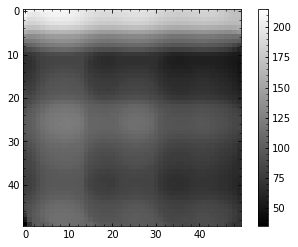

In [13]:
#zoomed in inpainted region, T=10
xo,yo=start
xf,yf=start+window_size
f2 = inpaint(init,start,window_size,time=10)
plt.imshow(f2[xo:xf,yo:yf],cmap ="gray")
plt.colorbar()

#chi-squared test for just the window parts of the image
chisq = p2p2.chisquared(f2[xo:xf,yo:yf],clown_grey[xo:xf,yo:yf])
print("okay the chi-squared value for just this part of the image is", chisq)

okay the chi-squared value for just this part of the image is 0.00034144063281071505


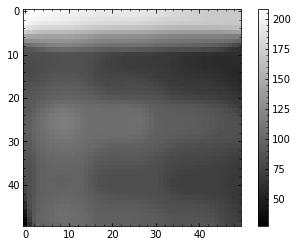

In [14]:
#zoomed in inpainted region, T=50, time to run ~ 1-2 min
xo,yo=start
xf,yf=start+window_size
f3 = inpaint(init,start,window_size,time=50)
plt.imshow(f3[xo:xf,yo:yf],cmap ="gray")
plt.colorbar()

#chi-squared test for just the window parts of the image
chisq = p2p2.chisquared(f3[xo:xf,yo:yf],clown_grey[xo:xf,yo:yf])
print("okay the chi-squared value for just this part of the image is", chisq)

## How big of a hole can we cut?
One question we set out to answer when we started was "how big of a hole can we cut in the image before our inpainting method doesn't do a good job?" Here we attempt to answer this question. We try a small hole (10x10), a medium hole (40x40), and a BIG hole (150x150).
### Bird

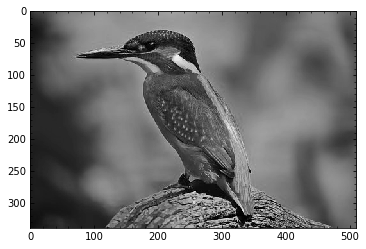

In [15]:
#small hole
start=np.array([100,250])
window_size=np.array([10,10])
init=p2p2.make_hole(bird_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)

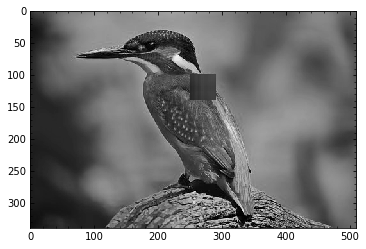

In [16]:
#medium hole
start=np.array([100,250])
window_size=np.array([40,40])
init=p2p2.make_hole(bird_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)

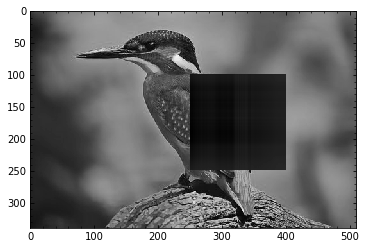

In [17]:
#big hole
start=np.array([100,250])
window_size=np.array([150,150])
init=p2p2.make_hole(bird_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)
#yikes

Okay, so it doesn't do a great job. It kind of just looks like an average over the whole image, or makes it look like the start position. However, this is what the implementation is supposed to do. We didn't expect for it to look good for huge holes. 

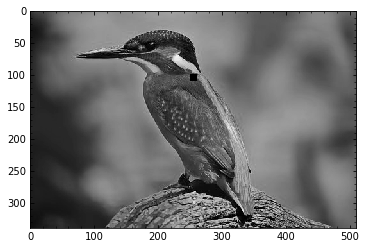

In [18]:
init = p2p2.make_hole(bird_grey, start = start, window_size = (10,10))
plt.imshow(init, cmap = "gray")

### Clown
Now we will try the same thing, but for the clown. The clown image has higher contrast, so it's possible that we might be able to get away with slightly larger holes.

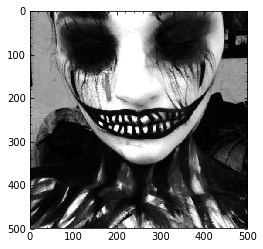

In [19]:
#small hole
start=np.array([300,220])
window_size=np.array([10,10])
init=p2p2.make_hole(clown_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)

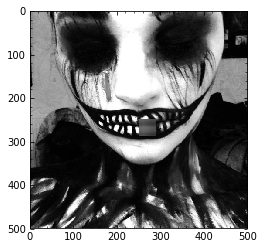

In [20]:
#medium hole
start=np.array([250,250])
window_size=np.array([40,40])
init=p2p2.make_hole(clown_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)

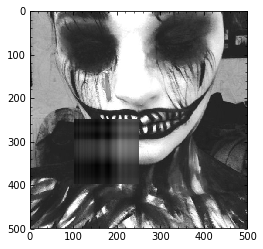

In [21]:
#big hole
start=np.array([250,100])
window_size=np.array([150,150])
init=p2p2.make_hole(clown_grey,window_size = window_size,start=start)
f = inpaint(init,start,window_size)
#yikes again

Yeah so, it's pretty bad, but maybe not as bad visually for the clown as it was for the bird, possibly because of the higher contrast in the image tricking your eye a little. Either way though, we have to remember that the large hole is just going to be bad. There's not much we could do.